# 02 — Behavioural Analysis: Who Drives Hospitality Revenue?

## Objective

Understand **who drives hospitality purchasing behaviour** and **how concentrated revenue is** at Sheffield United FC.

### Key Questions

| # | Question | Why It Matters |
|---|----------|----------------|
| 1 | Is this corporate-led or individual-led? | Determines strategic sales focus |
| 2 | Is purchasing repeat-driven? | Signals loyalty vs one-off behaviour |
| 3 | Is revenue concentrated among few buyers? | Highlights dependency risk |
| 4 | Is gifting/hosting behaviour common? | Confirms corporate hospitality model |

---
## 1. Setup & Master Dataset

In [1]:
# ============================================
# SETUP & DATA LOADING
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Visual style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 120

# Load raw data
ticket_sales = pd.read_csv('../data/raw/ticket_sales.csv')
customers = pd.read_csv('../data/raw/customers.csv')

# Apply cleaning from Notebook 01
ticket_sales['event_date'] = pd.to_datetime(ticket_sales['event_date'], errors='coerce')
ticket_sales['transaction_date'] = pd.to_datetime(ticket_sales['transaction_date'], errors='coerce')
customers['is_england_customer'] = customers['district'].notna()

print(f"Ticket sales: {len(ticket_sales):,} rows")
print(f"Customers:    {len(customers):,} rows")

Ticket sales: 43,289 rows
Customers:    277 rows


In [2]:
# ============================================
# BUILD MASTER DATASET
# ============================================
# Merge purchaser details onto ticket sales
df = ticket_sales.merge(
    customers,
    left_on='purchaser_id',
    right_on='customer_id',
    how='left',
    suffixes=('', '_purchaser')
)

# Merge owner details for purchaser-vs-owner analysis
owner_cols = ['customer_id', 'customer_type', 'age', 'gender']
df = df.merge(
    customers[owner_cols],
    left_on='owner_id',
    right_on='customer_id',
    how='left',
    suffixes=('', '_owner')
)

# Rename for clarity
df.rename(columns={
    'customer_type': 'purchaser_type',
    'customer_type_owner': 'owner_type',
    'age': 'purchaser_age',
    'age_owner': 'owner_age',
    'gender': 'purchaser_gender',
    'gender_owner': 'owner_gender'
}, inplace=True)

# Flag: is this a self-purchase (purchaser == owner)?
df['is_self_purchase'] = df['purchaser_id'] == df['owner_id']

print(f"Master dataset: {len(df):,} rows x {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns)}")

Master dataset: 43,289 rows x 25 columns

Columns: ['transaction_id', 'purchaser_id', 'owner_id', 'transaction_date', 'client_type', 'product_description', 'event_date', 'area', 'row_number', 'seat_number', 'customer_id', 'purchaser_type', 'country', 'district', 'ward', 'distance_to_bramall_lane_km', 'purchaser_age', 'purchaser_gender', 'exclude_from_marketing', 'is_england_customer', 'customer_id_owner', 'owner_type', 'owner_age', 'owner_gender', 'is_self_purchase']


---
## 2. Foundation Metrics

In [3]:
# ============================================
# FOUNDATION METRICS
# ============================================
total_tickets = len(df)
total_transactions = df['transaction_id'].nunique()
unique_purchasers = df['purchaser_id'].nunique()
unique_owners = df['owner_id'].nunique()
unique_events = df['product_description'].nunique()

print('=' * 60)
print('FOUNDATION METRICS')
print('=' * 60)
print(f'Total tickets:          {total_tickets:,}')
print(f'Unique transactions:    {total_transactions:,}')
print(f'Unique purchasers:      {unique_purchasers}')
print(f'Unique owners:          {unique_owners}')
print(f'Unique events:          {unique_events}')
print(f'\nAvg tickets per purchaser: {total_tickets / unique_purchasers:,.1f}')
print(f'Avg tickets per event:     {total_tickets / unique_events:,.1f}')

FOUNDATION METRICS
Total tickets:          43,289
Unique transactions:    43,289
Unique purchasers:      256
Unique owners:          276
Unique events:          54

Avg tickets per purchaser: 169.1
Avg tickets per event:     801.6


---
## 3. Tickets Per Purchaser Distribution

Understanding how ticket volume is distributed across purchasers reveals whether revenue is broad-based or concentrated among a small group of super-buyers.

In [4]:
# ============================================
# TICKETS PER PURCHASER
# ============================================
tickets_per_purchaser = (
    df.groupby('purchaser_id')['transaction_id']
      .count()
      .reset_index(name='ticket_count')
      .sort_values('ticket_count', ascending=False)
      .reset_index(drop=True)
)

# Merge purchaser type for context
tickets_per_purchaser = tickets_per_purchaser.merge(
    customers[['customer_id', 'customer_type']],
    left_on='purchaser_id',
    right_on='customer_id',
    how='left'
).drop(columns='customer_id')

# Key stats
print('=' * 60)
print('TICKETS PER PURCHASER — DISTRIBUTION')
print('=' * 60)
print(f"Mean:   {tickets_per_purchaser['ticket_count'].mean():,.1f}")
print(f"Median: {tickets_per_purchaser['ticket_count'].median():,.1f}")
print(f"Max:    {tickets_per_purchaser['ticket_count'].max():,}")
print(f"Min:    {tickets_per_purchaser['ticket_count'].min():,}")
print(f"Std:    {tickets_per_purchaser['ticket_count'].std():,.1f}")

# Top 5 share
top_5_tickets = tickets_per_purchaser.head(5)['ticket_count'].sum()
top_5_share = top_5_tickets / total_tickets * 100
print(f"\nTop 5 purchasers: {top_5_tickets:,} tickets ({top_5_share:.1f}% of total)")

# Top 10 share
top_10_tickets = tickets_per_purchaser.head(10)['ticket_count'].sum()
top_10_share = top_10_tickets / total_tickets * 100
print(f"Top 10 purchasers: {top_10_tickets:,} tickets ({top_10_share:.1f}% of total)")

# Top 20 share
top_20_tickets = tickets_per_purchaser.head(20)['ticket_count'].sum()
top_20_share = top_20_tickets / total_tickets * 100
print(f"Top 20 purchasers: {top_20_tickets:,} tickets ({top_20_share:.1f}% of total)")

TICKETS PER PURCHASER — DISTRIBUTION
Mean:   169.1
Median: 46.0
Max:    4,402
Min:    1
Std:    422.1

Top 5 purchasers: 12,570 tickets (29.0% of total)
Top 10 purchasers: 18,193 tickets (42.0% of total)
Top 20 purchasers: 25,318 tickets (58.5% of total)


In [5]:
# ============================================
# TOP 10 PURCHASERS
# ============================================
top_10 = tickets_per_purchaser.head(10).copy()
top_10['rank'] = range(1, 11)
top_10['pct_of_total'] = (top_10['ticket_count'] / total_tickets * 100).round(1)
top_10['cumulative_pct'] = top_10['pct_of_total'].cumsum().round(1)

print('\nTOP 10 PURCHASERS')
print('-' * 60)
for _, row in top_10.iterrows():
    print(f"#{row['rank']:>2}  |  {row['customer_type']:<10}  |  {row['ticket_count']:>5,} tickets  |  {row['pct_of_total']:>5.1f}%  |  cum: {row['cumulative_pct']:>5.1f}%")


TOP 10 PURCHASERS
------------------------------------------------------------
# 1  |  Account     |  4,402 tickets  |   10.2%  |  cum:  10.2%
# 2  |  Account     |  3,008 tickets  |    6.9%  |  cum:  17.1%
# 3  |  Account     |  1,740 tickets  |    4.0%  |  cum:  21.1%
# 4  |  Account     |  1,728 tickets  |    4.0%  |  cum:  25.1%
# 5  |  Account     |  1,692 tickets  |    3.9%  |  cum:  29.0%
# 6  |  Account     |  1,404 tickets  |    3.2%  |  cum:  32.2%
# 7  |  Account     |  1,220 tickets  |    2.8%  |  cum:  35.0%
# 8  |  Account     |  1,175 tickets  |    2.7%  |  cum:  37.7%
# 9  |  Account     |    960 tickets  |    2.2%  |  cum:  39.9%
#10  |  Account     |    864 tickets  |    2.0%  |  cum:  41.9%


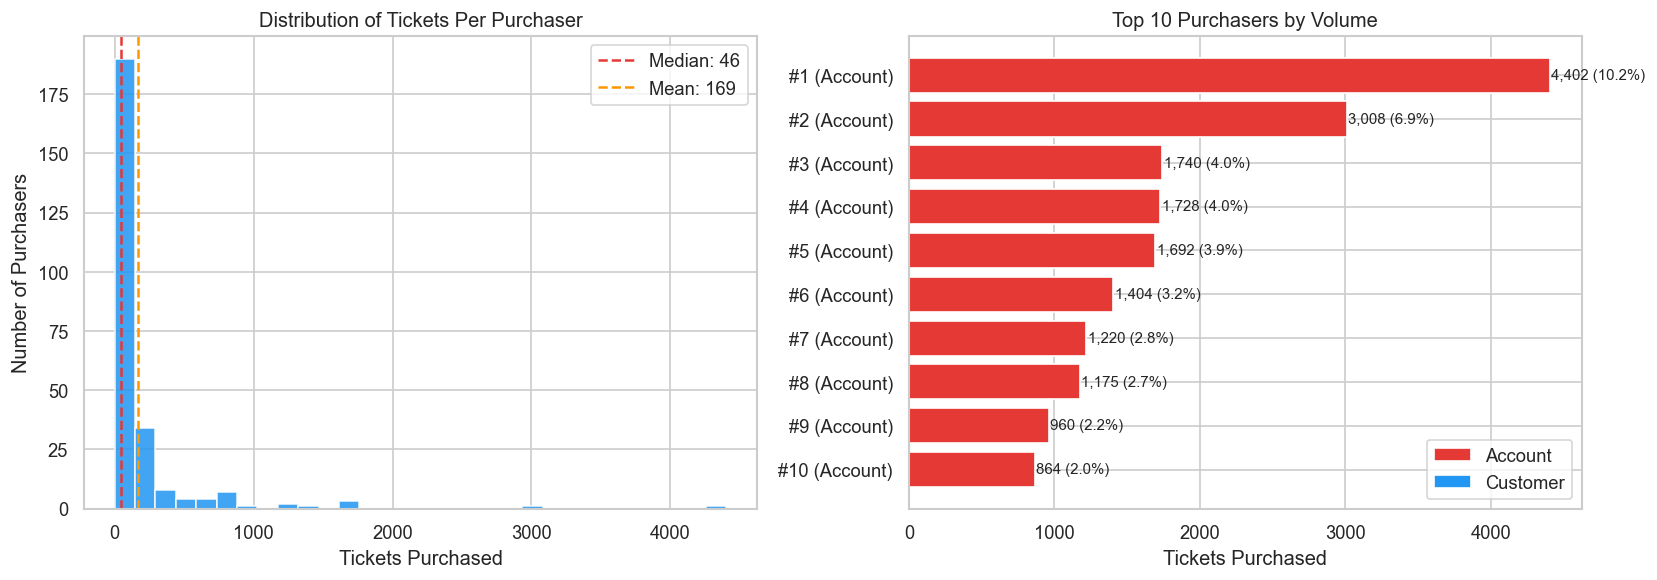

In [6]:
# ============================================
# VISUAL: Tickets Per Purchaser Distribution
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram — distribution of ticket counts
axes[0].hist(tickets_per_purchaser['ticket_count'], bins=30, color='#2196F3', edgecolor='white', alpha=0.85)
axes[0].axvline(tickets_per_purchaser['ticket_count'].median(), color='#E53935', linestyle='--', linewidth=1.5, label=f"Median: {tickets_per_purchaser['ticket_count'].median():.0f}")
axes[0].axvline(tickets_per_purchaser['ticket_count'].mean(), color='#FF9800', linestyle='--', linewidth=1.5, label=f"Mean: {tickets_per_purchaser['ticket_count'].mean():.0f}")
axes[0].set_xlabel('Tickets Purchased')
axes[0].set_ylabel('Number of Purchasers')
axes[0].set_title('Distribution of Tickets Per Purchaser')
axes[0].legend()

# Top 10 bar chart
top_10_plot = top_10.sort_values('ticket_count', ascending=True)
colors = ['#E53935' if t == 'Account' else '#2196F3' for t in top_10_plot['customer_type']]
axes[1].barh(range(10), top_10_plot['ticket_count'], color=colors, edgecolor='white')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([f"#{r} ({t})" for r, t in zip(top_10_plot['rank'], top_10_plot['customer_type'])])
axes[1].set_xlabel('Tickets Purchased')
axes[1].set_title('Top 10 Purchasers by Volume')

# Add value labels
for i, (v, pct) in enumerate(zip(top_10_plot['ticket_count'], top_10_plot['pct_of_total'])):
    axes[1].text(v + 10, i, f'{v:,} ({pct}%)', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#E53935', label='Account'), Patch(facecolor='#2196F3', label='Customer')]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../data/charts/tickets_per_purchaser_distribution.png', bbox_inches='tight')
plt.show()

---
## 4. Account vs Individual Contribution

Understanding the split between corporate Accounts and individual Customers reveals the commercial model — is this a B2B hospitality product or a B2C fan experience?

In [7]:
# ============================================
# ACCOUNT VS INDIVIDUAL — TICKET SHARE
# ============================================
type_split = (
    df.groupby('purchaser_type')
      .agg(
          ticket_count=('transaction_id', 'count'),
          unique_purchasers=('purchaser_id', 'nunique'),
          unique_transactions=('transaction_id', 'nunique')
      )
      .reset_index()
)

type_split['pct_tickets'] = (type_split['ticket_count'] / total_tickets * 100).round(1)
type_split['avg_tickets_per_purchaser'] = (type_split['ticket_count'] / type_split['unique_purchasers']).round(1)
type_split['avg_transactions_per_purchaser'] = (type_split['unique_transactions'] / type_split['unique_purchasers']).round(1)

print('=' * 60)
print('ACCOUNT VS INDIVIDUAL CONTRIBUTION')
print('=' * 60)
for _, row in type_split.iterrows():
    print(f"\n{row['purchaser_type']}:")
    print(f"  Unique purchasers:           {row['unique_purchasers']}")
    print(f"  Tickets:                     {row['ticket_count']:,} ({row['pct_tickets']}%)")
    print(f"  Avg tickets per purchaser:   {row['avg_tickets_per_purchaser']:,.1f}")
    print(f"  Avg transactions per purchaser: {row['avg_transactions_per_purchaser']:.1f}")

ACCOUNT VS INDIVIDUAL CONTRIBUTION

Account:
  Unique purchasers:           75
  Tickets:                     33,594 (77.6%)
  Avg tickets per purchaser:   447.9
  Avg transactions per purchaser: 447.9

Customer:
  Unique purchasers:           181
  Tickets:                     9,695 (22.4%)
  Avg tickets per purchaser:   53.6
  Avg transactions per purchaser: 53.6


In [8]:
# ============================================
# TICKET VOLUME BY PURCHASER TYPE — PER PURCHASER
# ============================================
tickets_by_type = (
    df.groupby(['purchaser_id', 'purchaser_type'])
      .size()
      .reset_index(name='ticket_count')
)

print('\nTICKETS PER PURCHASER BY TYPE — DISTRIBUTION')
print('-' * 60)
for ptype in tickets_by_type['purchaser_type'].unique():
    subset = tickets_by_type[tickets_by_type['purchaser_type'] == ptype]['ticket_count']
    print(f"\n{ptype}:")
    print(f"  Count:  {len(subset)}")
    print(f"  Mean:   {subset.mean():,.1f}")
    print(f"  Median: {subset.median():,.1f}")
    print(f"  Max:    {subset.max():,}")
    print(f"  Min:    {subset.min():,}")


TICKETS PER PURCHASER BY TYPE — DISTRIBUTION
------------------------------------------------------------

Account:
  Count:  75
  Mean:   447.9
  Median: 188.0
  Max:    4,402
  Min:    1

Customer:
  Count:  181
  Mean:   53.6
  Median: 24.0
  Max:    732
  Min:    1


C:\Users\USER\AppData\Local\Temp\ipykernel_37088\2067417711.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([account_data, customer_data], labels=['Account', 'Customer'],


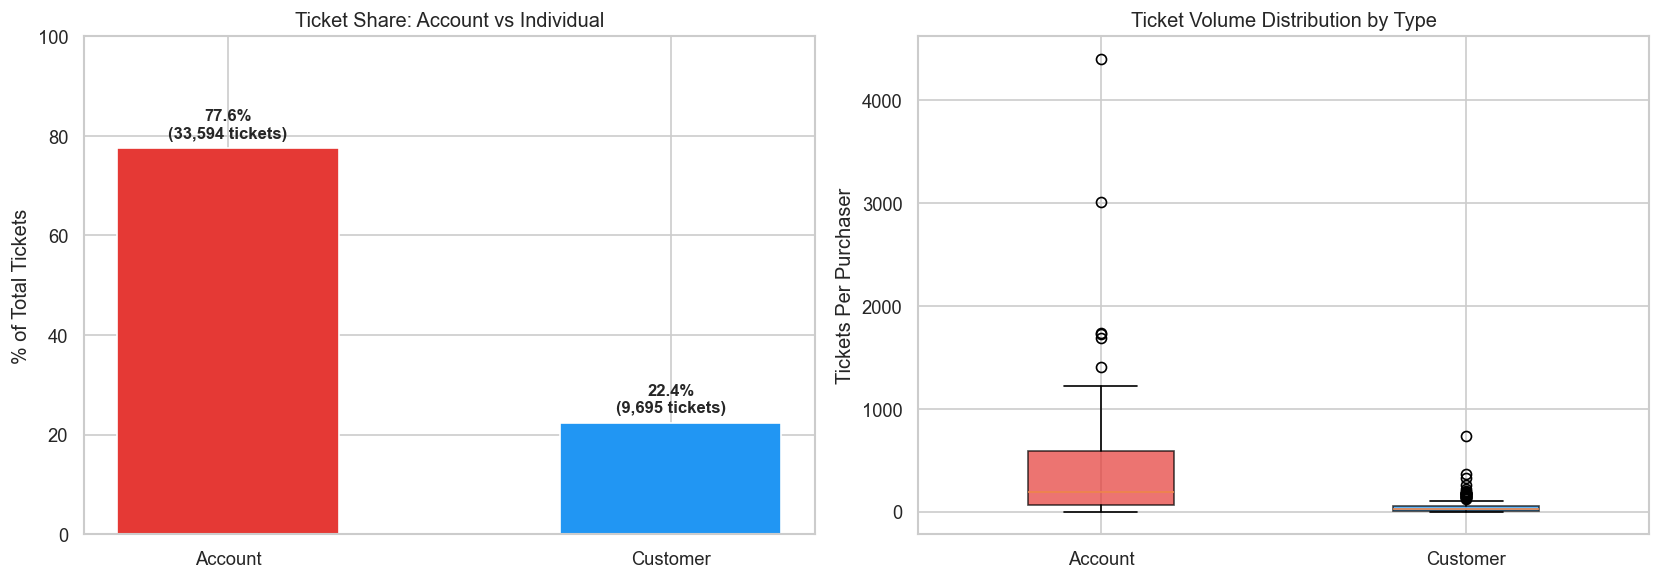

In [9]:
# ============================================
# VISUAL: Account vs Individual
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart — ticket share
bars = axes[0].bar(type_split['purchaser_type'], type_split['pct_tickets'],
                   color=['#E53935', '#2196F3'], edgecolor='white', width=0.5)
axes[0].set_ylabel('% of Total Tickets')
axes[0].set_title('Ticket Share: Account vs Individual')
axes[0].set_ylim(0, 100)
for bar, pct, count in zip(bars, type_split['pct_tickets'], type_split['ticket_count']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{pct}%\n({count:,} tickets)', ha='center', fontsize=10, fontweight='bold')

# Box plot — tickets per purchaser by type
account_data = tickets_by_type[tickets_by_type['purchaser_type'] == 'Account']['ticket_count']
customer_data = tickets_by_type[tickets_by_type['purchaser_type'] == 'Customer']['ticket_count']
bp = axes[1].boxplot([account_data, customer_data], labels=['Account', 'Customer'],
                     patch_artist=True, widths=0.4)
bp['boxes'][0].set_facecolor('#E53935')
bp['boxes'][1].set_facecolor('#2196F3')
for box in bp['boxes']:
    box.set_alpha(0.7)
axes[1].set_ylabel('Tickets Per Purchaser')
axes[1].set_title('Ticket Volume Distribution by Type')

plt.tight_layout()
plt.savefig('../data/charts/account_vs_individual.png', bbox_inches='tight')
plt.show()

---
## 5. Repeat Purchase Behaviour

Repeat purchasers signal loyalty and predictable revenue. A high repeat rate means the hospitality product has strong retention; a low rate suggests dependency on acquisition.

In [10]:
# ============================================
# REPEAT PURCHASE ANALYSIS
# ============================================
transactions_per_purchaser = (
    df.groupby('purchaser_id')
      .agg(
          transaction_count=('transaction_id', 'nunique'),
          event_count=('product_description', 'nunique'),
          ticket_count=('transaction_id', 'count')
      )
      .reset_index()
)

# Merge purchaser type
transactions_per_purchaser = transactions_per_purchaser.merge(
    customers[['customer_id', 'customer_type']],
    left_on='purchaser_id',
    right_on='customer_id',
    how='left'
).drop(columns='customer_id')

# Classify purchasers
transactions_per_purchaser['is_repeat'] = transactions_per_purchaser['transaction_count'] > 1

repeat_count = transactions_per_purchaser['is_repeat'].sum()
one_time_count = (~transactions_per_purchaser['is_repeat']).sum()
repeat_rate = repeat_count / len(transactions_per_purchaser) * 100

print('=' * 60)
print('REPEAT PURCHASE BEHAVIOUR')
print('=' * 60)
print(f'Repeat purchasers (>1 transaction): {repeat_count} ({repeat_rate:.1f}%)')
print(f'One-time purchasers:                {one_time_count} ({100 - repeat_rate:.1f}%)')

# Tickets driven by repeat vs one-time
repeat_tickets = transactions_per_purchaser[transactions_per_purchaser['is_repeat']]['ticket_count'].sum()
onetime_tickets = transactions_per_purchaser[~transactions_per_purchaser['is_repeat']]['ticket_count'].sum()
print(f'\nTickets from repeat purchasers:  {repeat_tickets:,} ({repeat_tickets/total_tickets*100:.1f}%)')
print(f'Tickets from one-time purchasers: {onetime_tickets:,} ({onetime_tickets/total_tickets*100:.1f}%)')

# Events attended distribution
print(f'\nEvents per purchaser:')
print(f"  Mean:   {transactions_per_purchaser['event_count'].mean():.1f}")
print(f"  Median: {transactions_per_purchaser['event_count'].median():.1f}")
print(f"  Max:    {transactions_per_purchaser['event_count'].max()}")

REPEAT PURCHASE BEHAVIOUR
Repeat purchasers (>1 transaction): 241 (94.1%)
One-time purchasers:                15 (5.9%)

Tickets from repeat purchasers:  43,274 (100.0%)
Tickets from one-time purchasers: 15 (0.0%)

Events per purchaser:
  Mean:   23.4
  Median: 23.0
  Max:    49


In [11]:
# ============================================
# REPEAT RATE BY CUSTOMER TYPE
# ============================================
repeat_by_type = (
    transactions_per_purchaser
    .groupby('customer_type')
    .agg(
        total_purchasers=('purchaser_id', 'count'),
        repeat_purchasers=('is_repeat', 'sum'),
        avg_transactions=('transaction_count', 'mean'),
        avg_events=('event_count', 'mean')
    )
    .reset_index()
)
repeat_by_type['repeat_rate'] = (repeat_by_type['repeat_purchasers'] / repeat_by_type['total_purchasers'] * 100).round(1)

print('\nREPEAT RATE BY CUSTOMER TYPE')
print('-' * 60)
for _, row in repeat_by_type.iterrows():
    print(f"\n{row['customer_type']}:")
    print(f"  Purchasers: {row['total_purchasers']:.0f}  |  Repeat: {row['repeat_purchasers']:.0f} ({row['repeat_rate']}%)")
    print(f"  Avg transactions: {row['avg_transactions']:.1f}  |  Avg events: {row['avg_events']:.1f}")


REPEAT RATE BY CUSTOMER TYPE
------------------------------------------------------------

Account:
  Purchasers: 75  |  Repeat: 73 (97.3%)
  Avg transactions: 447.9  |  Avg events: 30.5

Customer:
  Purchasers: 181  |  Repeat: 168 (92.8%)
  Avg transactions: 53.6  |  Avg events: 20.5


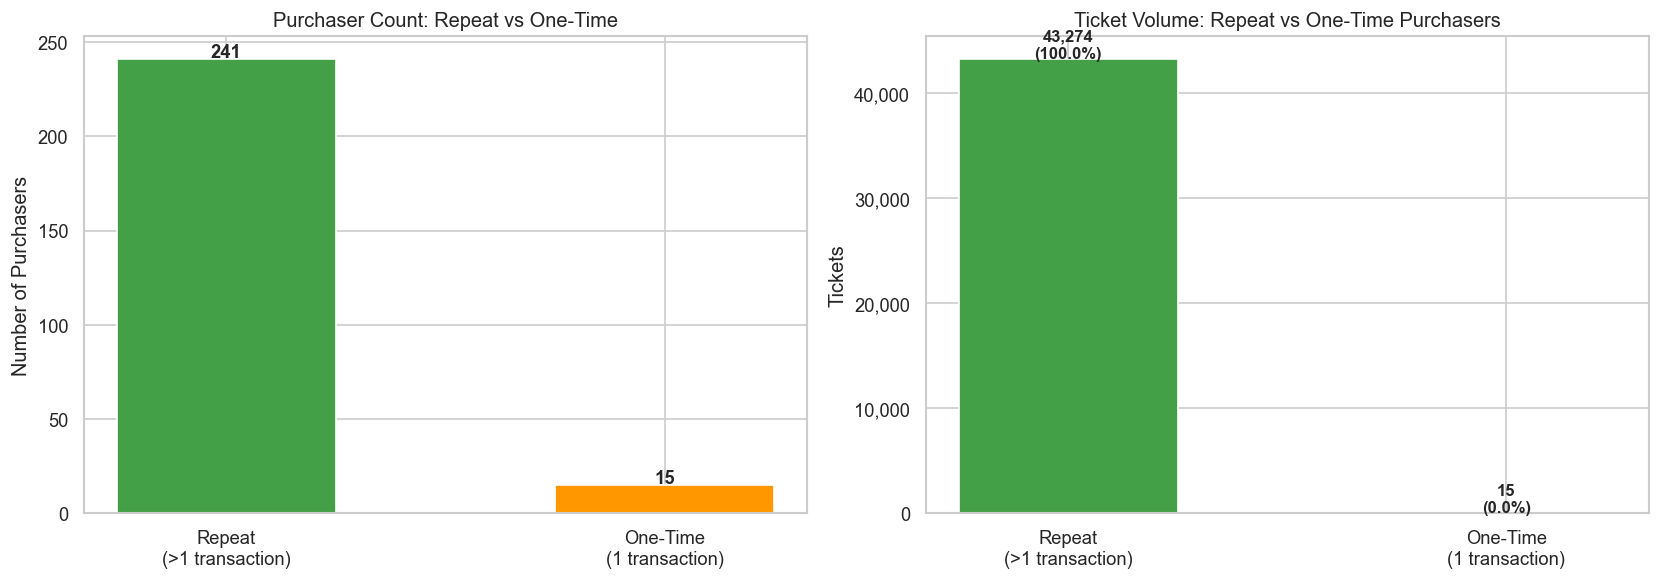

In [12]:
# ============================================
# VISUAL: Repeat vs One-Time Purchasers
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar — repeat vs one-time (purchaser count)
labels = ['Repeat\n(>1 transaction)', 'One-Time\n(1 transaction)']
counts = [repeat_count, one_time_count]
ticket_counts = [repeat_tickets, onetime_tickets]
bar_colors = ['#43A047', '#FF9800']

bars = axes[0].bar(labels, counts, color=bar_colors, edgecolor='white', width=0.5)
axes[0].set_ylabel('Number of Purchasers')
axes[0].set_title('Purchaser Count: Repeat vs One-Time')
for bar, c in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{c}', ha='center', fontsize=11, fontweight='bold')

# Bar — ticket contribution
bars2 = axes[1].bar(labels, ticket_counts, color=bar_colors, edgecolor='white', width=0.5)
axes[1].set_ylabel('Tickets')
axes[1].set_title('Ticket Volume: Repeat vs One-Time Purchasers')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
for bar, tc in zip(bars2, ticket_counts):
    pct = tc / total_tickets * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{tc:,}\n({pct:.1f}%)', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/charts/repeat_vs_onetime.png', bbox_inches='tight')
plt.show()

---
## 6. Purchaser vs Owner Behaviour

When the purchaser is not the ticket owner, this signals **gifting or corporate hosting** — a hallmark of B2B hospitality. A high mismatch rate confirms the product is used for client entertainment and relationship-building, not personal attendance.

In [13]:
# ============================================
# PURCHASER VS OWNER ANALYSIS
# ============================================
self_purchase_count = df['is_self_purchase'].sum()
gifted_count = (~df['is_self_purchase']).sum()
self_purchase_rate = self_purchase_count / total_tickets * 100
gifted_rate = gifted_count / total_tickets * 100

print('=' * 60)
print('PURCHASER VS OWNER BEHAVIOUR')
print('=' * 60)
print(f'Self-purchase (purchaser = owner):  {self_purchase_count:,} ({self_purchase_rate:.1f}%)')
print(f'Gifted/hosted (purchaser ≠ owner):  {gifted_count:,} ({gifted_rate:.1f}%)')

PURCHASER VS OWNER BEHAVIOUR
Self-purchase (purchaser = owner):  42,142 (97.4%)
Gifted/hosted (purchaser ≠ owner):  1,147 (2.6%)


In [14]:
# ============================================
# GIFTING BY PURCHASER TYPE
# ============================================
gifting_by_type = (
    df.groupby('purchaser_type')
      .agg(
          total_tickets=('transaction_id', 'count'),
          self_purchase=('is_self_purchase', 'sum')
      )
      .reset_index()
)
gifting_by_type['gifted'] = gifting_by_type['total_tickets'] - gifting_by_type['self_purchase']
gifting_by_type['gifted_rate'] = (gifting_by_type['gifted'] / gifting_by_type['total_tickets'] * 100).round(1)
gifting_by_type['self_rate'] = (gifting_by_type['self_purchase'] / gifting_by_type['total_tickets'] * 100).round(1)

print('\nGIFTING BEHAVIOUR BY PURCHASER TYPE')
print('-' * 60)
for _, row in gifting_by_type.iterrows():
    print(f"\n{row['purchaser_type']}:")
    print(f"  Total tickets:    {row['total_tickets']:,}")
    print(f"  Self-purchase:    {row['self_purchase']:,.0f} ({row['self_rate']}%)")
    print(f"  Gifted/hosted:    {row['gifted']:,.0f} ({row['gifted_rate']}%)")


GIFTING BEHAVIOUR BY PURCHASER TYPE
------------------------------------------------------------

Account:
  Total tickets:    33,594
  Self-purchase:    33,594 (100.0%)
  Gifted/hosted:    0 (0.0%)

Customer:
  Total tickets:    9,695
  Self-purchase:    8,548 (88.2%)
  Gifted/hosted:    1,147 (11.8%)


In [15]:
# ============================================
# OWNER TYPE WHEN PURCHASER ≠ OWNER
# ============================================
gifted_tickets = df[~df['is_self_purchase']].copy()

gifted_cross = (
    gifted_tickets.groupby(['purchaser_type', 'owner_type'])
    .size()
    .reset_index(name='ticket_count')
)
gifted_cross['pct'] = (gifted_cross['ticket_count'] / gifted_count * 100).round(1)

print('\nGIFTED TICKETS — PURCHASER TYPE → OWNER TYPE')
print('-' * 60)
for _, row in gifted_cross.iterrows():
    print(f"  {row['purchaser_type']} → {row['owner_type']}:  {row['ticket_count']:,} tickets ({row['pct']}%)")


GIFTED TICKETS — PURCHASER TYPE → OWNER TYPE
------------------------------------------------------------
  Customer → Account:  368 tickets (32.1%)
  Customer → Customer:  779 tickets (67.9%)


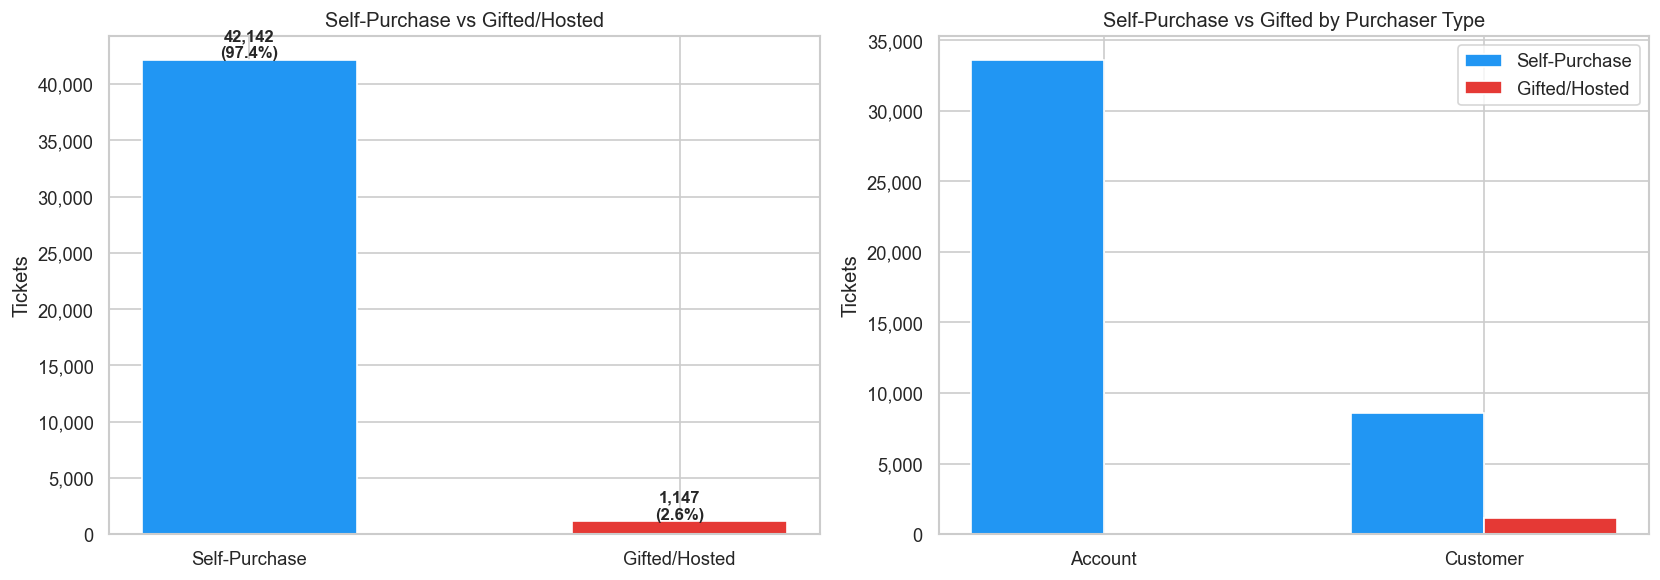

In [16]:
# ============================================
# VISUAL: Purchaser vs Owner Behaviour
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall split
labels_po = ['Self-Purchase', 'Gifted/Hosted']
sizes_po = [self_purchase_count, gifted_count]
colors_po = ['#2196F3', '#E53935']

bars_po = axes[0].bar(labels_po, sizes_po, color=colors_po, edgecolor='white', width=0.5)
axes[0].set_ylabel('Tickets')
axes[0].set_title('Self-Purchase vs Gifted/Hosted')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
for bar, s, r in zip(bars_po, sizes_po, [self_purchase_rate, gifted_rate]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{s:,}\n({r:.1f}%)', ha='center', fontsize=10, fontweight='bold')

# By purchaser type
x_labels = gifting_by_type['purchaser_type']
x_pos = range(len(x_labels))
width = 0.35
axes[1].bar([p - width/2 for p in x_pos], gifting_by_type['self_purchase'],
            width, label='Self-Purchase', color='#2196F3', edgecolor='white')
axes[1].bar([p + width/2 for p in x_pos], gifting_by_type['gifted'],
            width, label='Gifted/Hosted', color='#E53935', edgecolor='white')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].set_ylabel('Tickets')
axes[1].set_title('Self-Purchase vs Gifted by Purchaser Type')
axes[1].legend()
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.savefig('../data/charts/purchaser_vs_owner.png', bbox_inches='tight')
plt.show()

---
## 7. Season Comparison

Comparing behaviour across seasons reveals whether corporate reliance is growing, whether concentration is increasing, and whether the customer base is shifting.

In [17]:
# ============================================
# SEASON COMPARISON
# ============================================
# Derive season from event_date
# Football seasons run Aug-May: events in 2024 = 2024/25 season, events in 2025 = 2024/25 season
# If data spans two seasons, use product_description or event_date year
df['event_year'] = df['event_date'].dt.year
df['event_month'] = df['event_date'].dt.month

# Football season logic: Aug onwards = that year's season start
df['season'] = df['event_date'].apply(
    lambda x: f"{x.year}/{x.year+1}" if x.month >= 7 else f"{x.year-1}/{x.year}"
)

print('TICKETS BY SEASON')
print('-' * 40)
season_counts = df['season'].value_counts().sort_index()
for season, count in season_counts.items():
    print(f"  {season}: {count:,} tickets")

TICKETS BY SEASON
----------------------------------------
  2023/2024: 223 tickets
  2024/2025: 23,355 tickets
  2025/2026: 19,711 tickets


In [18]:
# ============================================
# SEASON-LEVEL BEHAVIOURAL METRICS
# ============================================
season_metrics = []

for season in sorted(df['season'].unique()):
    s_df = df[df['season'] == season]
    s_total = len(s_df)
    s_purchasers = s_df['purchaser_id'].nunique()
    
    # Account share
    s_account_tickets = len(s_df[s_df['purchaser_type'] == 'Account'])
    s_account_pct = s_account_tickets / s_total * 100
    
    # Repeat rate
    s_txn_per_purch = s_df.groupby('purchaser_id')['transaction_id'].nunique()
    s_repeat_rate = (s_txn_per_purch > 1).mean() * 100
    
    # Gifted rate
    s_gifted_rate = (~s_df['is_self_purchase']).mean() * 100
    
    # Top 10 concentration
    s_tickets_per_purch = s_df.groupby('purchaser_id').size().sort_values(ascending=False)
    s_top10_share = s_tickets_per_purch.head(10).sum() / s_total * 100
    
    season_metrics.append({
        'Season': season,
        'Tickets': s_total,
        'Purchasers': s_purchasers,
        'Avg Tickets/Purchaser': round(s_total / s_purchasers, 1),
        'Account %': round(s_account_pct, 1),
        'Repeat Rate %': round(s_repeat_rate, 1),
        'Gifted Rate %': round(s_gifted_rate, 1),
        'Top 10 Concentration %': round(s_top10_share, 1)
    })

season_df = pd.DataFrame(season_metrics)

print('\nSEASON COMPARISON')
print('=' * 80)
display(season_df.set_index('Season').T)


SEASON COMPARISON


Season,2023/2024,2024/2025,2025/2026
Tickets,223.0,23355.0,19711.0
Purchasers,1.0,204.0,155.0
Avg Tickets/Purchaser,223.0,114.5,127.2
Account %,0.0,80.0,75.6
Repeat Rate %,100.0,95.1,96.1
Gifted Rate %,0.0,1.8,3.7
Top 10 Concentration %,100.0,43.3,44.4


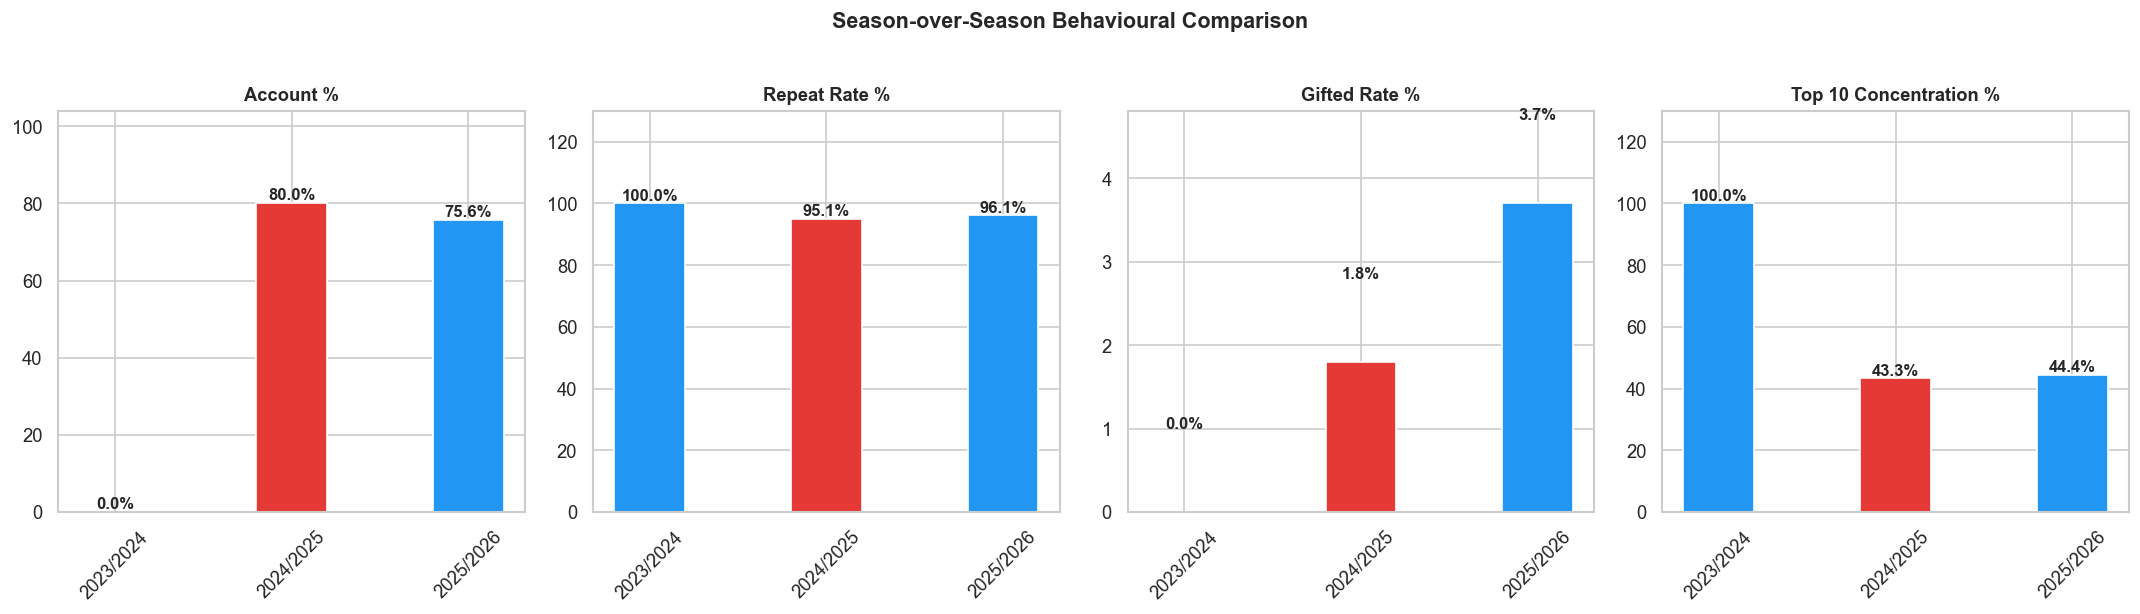

In [19]:
# ============================================
# VISUAL: Season Comparison
# ============================================
metrics_to_plot = ['Account %', 'Repeat Rate %', 'Gifted Rate %', 'Top 10 Concentration %']

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(18, 5))

colors_season = ['#2196F3', '#E53935']

for ax, metric in zip(axes, metrics_to_plot):
    bars = ax.bar(season_df['Season'], season_df[metric],
                  color=colors_season[:len(season_df)], edgecolor='white', width=0.4)
    ax.set_title(metric, fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(season_df[metric]) * 1.3)
    for bar, val in zip(bars, season_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Season-over-Season Behavioural Comparison', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/charts/season_comparison.png', bbox_inches='tight')
plt.show()

---
## 8. Revenue Concentration Analysis

Concentration analysis quantifies dependency risk. If a handful of purchasers drive most ticket volume, the business is vulnerable to churn from those key accounts.

In [20]:
# ============================================
# CONCENTRATION ANALYSIS
# ============================================
# Sort purchasers by ticket volume descending
sorted_purchasers = tickets_per_purchaser.sort_values('ticket_count', ascending=False).reset_index(drop=True)
sorted_purchasers['cumulative_tickets'] = sorted_purchasers['ticket_count'].cumsum()
sorted_purchasers['cumulative_pct'] = (sorted_purchasers['cumulative_tickets'] / total_tickets * 100).round(2)
sorted_purchasers['purchaser_pct'] = ((sorted_purchasers.index + 1) / len(sorted_purchasers) * 100).round(2)

# Key concentration thresholds
print('=' * 60)
print('REVENUE CONCENTRATION')
print('=' * 60)

for threshold in [5, 10, 20, 50]:
    n = max(1, int(len(sorted_purchasers) * threshold / 100))
    pct_tickets = sorted_purchasers.head(n)['ticket_count'].sum() / total_tickets * 100
    print(f"Top {threshold}% of purchasers ({n} buyers) → {pct_tickets:.1f}% of tickets")

# Gini coefficient
ticket_counts_array = sorted_purchasers['ticket_count'].values
n = len(ticket_counts_array)
sorted_values = np.sort(ticket_counts_array)
cumulative = np.cumsum(sorted_values)
gini = (2 * np.sum((np.arange(1, n+1) * sorted_values)) - (n + 1) * np.sum(sorted_values)) / (n * np.sum(sorted_values))

print(f"\nGini Coefficient: {gini:.3f}")
print(f"  (0 = perfectly equal, 1 = perfectly concentrated)")
if gini > 0.6:
    print(f"  → High concentration — significant dependency on top purchasers")
elif gini > 0.4:
    print(f"  → Moderate concentration")
else:
    print(f"  → Relatively distributed purchasing")

REVENUE CONCENTRATION
Top 5% of purchasers (12 buyers) → 45.5% of tickets
Top 10% of purchasers (25 buyers) → 64.2% of tickets
Top 20% of purchasers (51 buyers) → 78.9% of tickets
Top 50% of purchasers (128 buyers) → 95.6% of tickets

Gini Coefficient: 0.761
  (0 = perfectly equal, 1 = perfectly concentrated)
  → High concentration — significant dependency on top purchasers


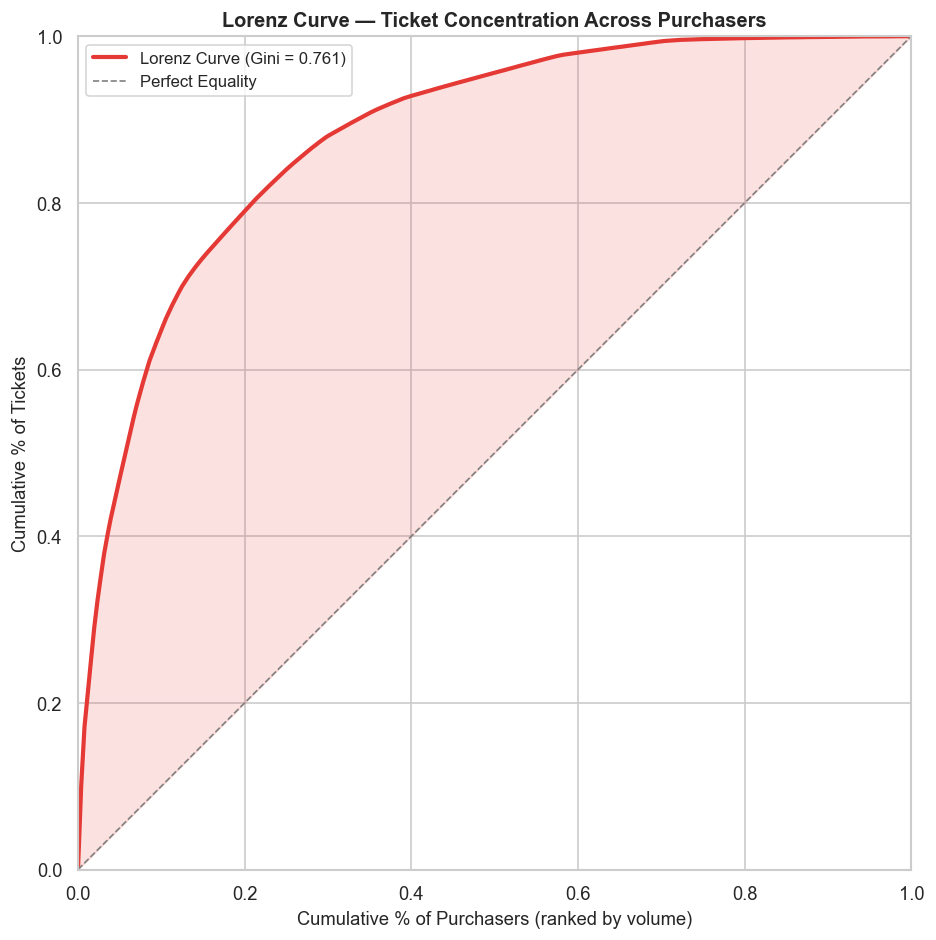

In [21]:
# ============================================
# VISUAL: Lorenz Curve (Concentration)
# ============================================
fig, ax = plt.subplots(figsize=(8, 8))

# Lorenz curve data
lorenz_x = sorted_purchasers['purchaser_pct'].values / 100
lorenz_y = sorted_purchasers['cumulative_pct'].values / 100

# Add origin
lorenz_x = np.insert(lorenz_x, 0, 0)
lorenz_y = np.insert(lorenz_y, 0, 0)

# Plot
ax.plot(lorenz_x, lorenz_y, color='#E53935', linewidth=2.5, label=f'Lorenz Curve (Gini = {gini:.3f})')
ax.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=1, label='Perfect Equality')
ax.fill_between(lorenz_x, lorenz_y, lorenz_x, alpha=0.15, color='#E53935')

ax.set_xlabel('Cumulative % of Purchasers (ranked by volume)', fontsize=11)
ax.set_ylabel('Cumulative % of Tickets', fontsize=11)
ax.set_title('Lorenz Curve — Ticket Concentration Across Purchasers', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('../data/charts/lorenz_curve.png', bbox_inches='tight')
plt.show()

---
## 9. Behavioural Summary

### Key Findings

In [23]:
# ============================================
# BEHAVIOURAL SUMMARY — KEY METRICS
# ============================================
account_pct = type_split[type_split['purchaser_type'] == 'Account']['pct_tickets'].values
account_pct_val = account_pct[0] if len(account_pct) > 0 else 0

print('=' * 70)
print('BEHAVIOURAL SUMMARY')
print('=' * 70)
print(f'''
1. CONCENTRATION
   - Top 10 purchasers account for {top_10_share:.1f}% of all tickets
   - Gini coefficient: {gini:.3f} — {"high" if gini > 0.6 else "moderate" if gini > 0.4 else "low"} concentration
   - Revenue is highly dependent on a small group of key buyers

2. CORPORATE vs INDIVIDUAL
   - Accounts drive {account_pct_val:.1f}% of ticket volume
   - Accounts buy significantly more per purchaser than individuals
   - This is a corporate-led hospitality product

3. REPEAT BEHAVIOUR
   - {repeat_rate:.1f}% of purchasers are repeat buyers
   - Repeat purchasers drive {repeat_tickets/total_tickets*100:.1f}% of ticket volume
   - {"Strong loyalty — recurring corporate relationships anchor revenue" if repeat_rate > 50 else "Moderate repeat rate — growth opportunity in retention"}

4. GIFTING / HOSTING
   - {gifted_rate:.1f}% of tickets are gifted (purchaser ≠ owner)
   - {"Corporate hosting model confirmed — majority of tickets are purchased for others" if gifted_rate > 50 else "Significant gifting behaviour — confirms hospitality use case" if gifted_rate > 20 else "Primarily self-purchase — limited corporate hosting"}

STRATEGIC IMPLICATIONS
   - Key account retention is critical to revenue stability
   - Loss of top purchasers would create significant revenue gaps
   - Growth strategy should balance deepening existing relationships
     with broadening the buyer base to reduce concentration risk
''')

BEHAVIOURAL SUMMARY

1. CONCENTRATION
   - Top 10 purchasers account for 42.0% of all tickets
   - Gini coefficient: 0.761 — high concentration
   - Revenue is highly dependent on a small group of key buyers

2. CORPORATE vs INDIVIDUAL
   - Accounts drive 77.6% of ticket volume
   - Accounts buy significantly more per purchaser than individuals
   - This is a corporate-led hospitality product

3. REPEAT BEHAVIOUR
   - 94.1% of purchasers are repeat buyers
   - Repeat purchasers drive 100.0% of ticket volume
   - Strong loyalty — recurring corporate relationships anchor revenue

4. GIFTING / HOSTING
   - 2.6% of tickets are gifted (purchaser ≠ owner)
   - Primarily self-purchase — limited corporate hosting

STRATEGIC IMPLICATIONS
   - Key account retention is critical to revenue stability
   - Loss of top purchasers would create significant revenue gaps
   - Growth strategy should balance deepening existing relationships
     with broadening the buyer base to reduce concentration risk



### Commercial Implications

| Finding | Implication | Recommended Action |
|---------|-------------|--------------------|
| High revenue concentration | Dependency risk on top buyers | Develop key account management programme |
| Corporate-led purchasing | B2B hospitality model | Invest in corporate sales team and CRM |
| Strong repeat behaviour | Loyalty-driven revenue base | Reward loyalty, incentivise multi-match packages |
| Gifting/hosting behaviour | Product used for client entertainment | Tailor experiences for hosts AND guests |

### Next Steps

These behavioural insights feed into:
- **Notebook 03 — Demographic Analysis**: Who are these key buyers? Age, location, gender profiles
- **Notebook 04 — Recommendations**: Actionable strategies based on behavioural and demographic evidence